In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import stanza
import re
import tensorflow as tf
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 데이터 불러오기

In [2]:
yr = pd.read_excel('yongsan_reviews_4005.xlsx', index_col=0)

In [3]:
#특수문자 제거
def cleasing(text): 
    repl ='' 
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)' # 자음, 모음 제거 
    text = re.sub(pattern= pattern, repl=repl, string=text) 
    pattern = '[^가-히\s]' # 특수기호 제거 
    text = re.sub(pattern= pattern, repl=repl, string=text) 
    pattern = '<[^>]*>' # html 제거 
    text = re.sub(pattern = pattern, repl='',string=text) 
    return text

yr['review'] = yr['review'].map(lambda x : cleasing(x))

In [4]:
#엑셀상에서 수기로 입력한 긍/부정 label 숫자형 데이터로 변환
yr['label'] = yr.label.astype('int')

In [5]:
yr = yr.reset_index(drop=True)
yr.head()

,review,label
0,깨끗하고 감성있는 분위기있는 숙소입니다,1
1,용산역 바로 분 거리라서 교통도 되게 좋고 주변에 마트 카페 맛집 등등 많아서 아주...,1
2,위치가 좋아 잘 쉬다갔습니다 하지만 아쉬운점이 한둘이 아니네요 방음이 약하다고는 하...,0
3,한강뷰가 그냥 너무좋아요 숙소도 깨끗하고 넓고 호텔이랑 크게 다를건없는것같아여,1
4,주차 제외하고는 아주 좋아요,1


In [6]:
yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  4004 non-null   object
 1   label   4004 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 47.0+ KB


In [6]:
#!pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
#코드 출처
#https://hong-yp-ml-records.tistory.com/99

In [7]:
from tqdm.notebook import tqdm

In [8]:
#맞춤법 검사 - 네이버 맞춤법
for i in tqdm(range(len(yr))):
    try:
        yr['review'] = spell_checker.check(yr['review'][i])
        yr['review'][i] = yr['review'].as_dict()['checked_review']
    except:
        pass
    
#출처: https://hong-yp-ml-records.tistory.com/99 [HONG YP's Data Science BLOG]

In [10]:
yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  4004 non-null   object
 1   label   4004 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 47.0+ KB


## 단어빈도

In [120]:
#TDM 생성
kiwi = Kiwi()
kiwi.prepare()

0

In [121]:
def extract_noun(text):
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos.startswith('N'):
            yield token

In [122]:
cv = CountVectorizer(max_features=2000, tokenizer=extract_noun)
tdm = cv.fit_transform(yr.loc[0:2000, 'review'])
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

In [123]:
#단어 글자수 2글자 이상
word_count= word_count[word_count.단어.apply(lambda x: len(str(x))>=2)]

In [124]:
word_count.sort_values('빈도', ascending = False).head(50)

,단어,빈도
913,숙소,806
134,공간,592
1260,위치,492
1935,호스트,488
791,사진,379
1685,친절,297
322,다음,266
1324,이용,254
1683,친구,250
37,감사,243


In [14]:
#단어구름 만들기
count_dic = word_count.set_index('단어')['빈도'].to_dict()

In [15]:
wc = WordCloud(font_path='C:/Users/love7/Downloads/NanumGothic.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)

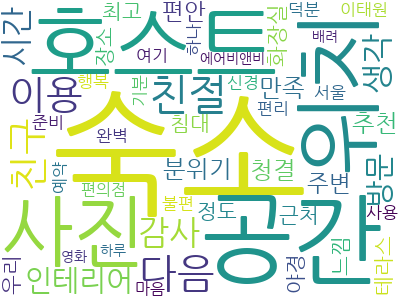

In [16]:
cloud = wc.generate_from_frequencies(count_dic)
cloud.to_image()

In [308]:
cloud.to_file('word_cloud.png')

In [125]:
#단어빈도에 tf-idf 적용
trans = TfidfTransformer()
tdm_tf = trans.fit_transform(tdm)

In [130]:
wc2 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    'tf-idf': tdm_tf.sum(axis=0).flat
    #빈도에 가중치를 곱한 값
})

In [131]:
#두 글자 이상
wc2= wc2[wc2.단어.apply(lambda x: len(str(x))>=2)]
wc2.sort_values('tf-idf', ascending=False).head(20)

,단어,tf-idf
913,숙소,109.186862
134,공간,102.587609
1260,위치,85.272822
1935,호스트,62.917691
791,사진,61.214909
1685,친절,52.101970
322,다음,48.305311
952,시간,45.130862
1324,이용,43.781116
724,분위기,43.718427


In [132]:
wc50 = wc2.sort_values('tf-idf', ascending=False).head(50)
wc50

,단어,tf-idf
913,숙소,109.186862
134,공간,102.587609
1260,위치,85.272822
1935,호스트,62.917691
791,사진,61.214909
1685,친절,52.101970
322,다음,48.305311
952,시간,45.130862
1324,이용,43.781116
724,분위기,43.718427


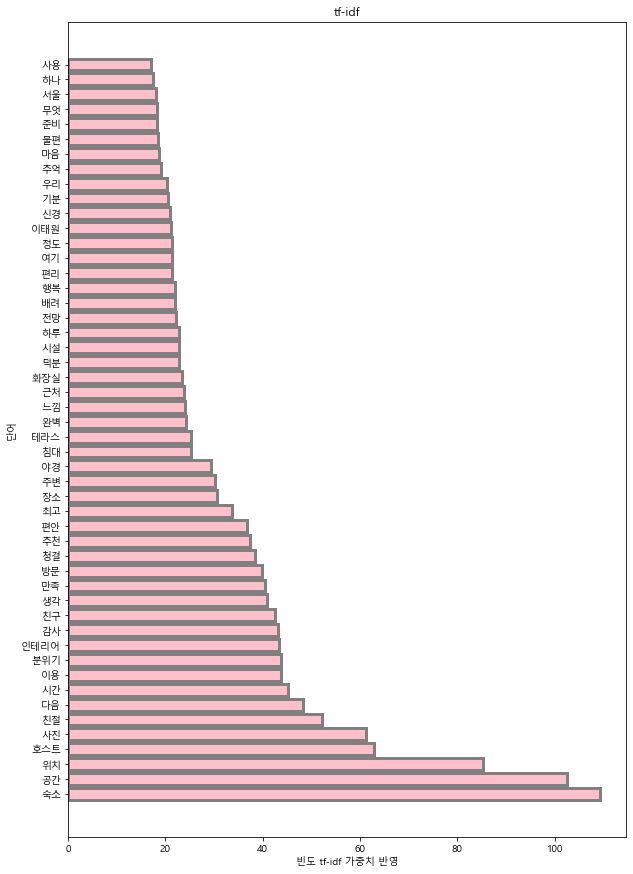

In [134]:
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "Malgun Gothic"
plt.figure(figsize=(10,15))
plt.title('tf-idf')
plt.xlabel('빈도 tf-idf 가중치 반영')
plt.ylabel('단어')
plt.barh(wc50['단어'], wc50['tf-idf'], color="pink",
        edgecolor="gray", linewidth=3, tick_label= wc50['단어'], log=False)
#plt.show()
plt.savefig('tfidf빈도.png')

In [135]:
#단어빈도에 로그 적용
def log(x):
    return np.log(x + 1)

In [136]:
word_count_log = word_count

In [137]:
word_count_log.빈도 = word_count.빈도.apply(log)

In [138]:
word_count_log.sort_values('빈도').tail(50)

,단어,빈도
645,배려,4.543295
1860,하루,4.543295
1100,에어비앤비,4.553877
1149,영화,4.553877
473,마음,4.564348
1806,편의점,4.584967
782,사용,4.615121
1913,행복,4.634729
1160,예약,4.644391
1856,하나,4.644391


In [139]:
wcl50 = word_count_log.sort_values('빈도', ascending=False).head(50)

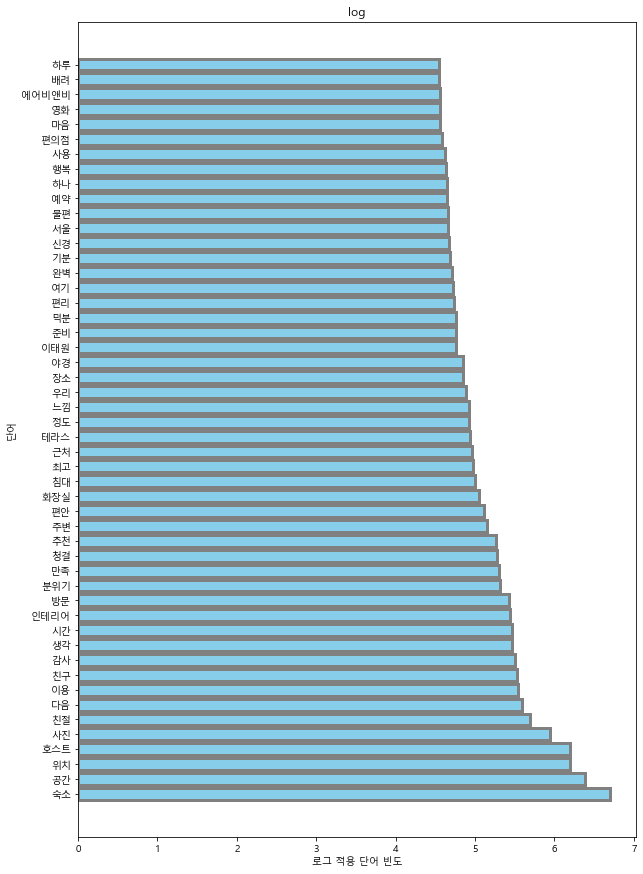

In [141]:
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "Malgun Gothic"
plt.figure(figsize=(10,15))
plt.title('log')
plt.xlabel('로그 적용 단어 빈도')
plt.ylabel('단어')
plt.barh(wcl50['단어'], wcl50['빈도'], color="skyblue",
        edgecolor="gray", linewidth=3, tick_label= wcl50['단어'], log=False)
#plt.show()
plt.savefig('로그적용빈도.png')

## 감성분석

In [13]:
#데이터 비율 맞추기
label_0 = yr.drop(yr.loc[yr['label'] == 1].index) #부정 
label_1 = yr.sample(n = len(label_0), random_state=126).reset_index(drop=True) #긍정

In [16]:
label_01 = pd.concat([label_0, label_1], ignore_index=True)

In [18]:
label_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  842 non-null    object
 1   label   842 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 10.0+ KB


①


In [17]:
#형태소 분석
def extract_keywords(text):
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos[0] in 'NV':
            yield f'{token}'

In [27]:
#DTM 생성
cv = TfidfVectorizer(max_features=400, tokenizer=extract_keywords)
dtm = cv.fit_transform(label_01.loc[0:842, 'review'])

In [28]:
words = cv.get_feature_names()

In [29]:
words

['가',
 '가격',
 '가깝',
 '가능',
 '가지',
 '가파르',
 '감동',
 '감사',
 '감성',
 '갖추',
 '같',
 '개',
 '거',
 '거기',
 '거리',
 '거실',
 '걱정',
 '건물',
 '걷',
 '것',
 '게임',
 '겨울',
 '경리단길',
 '경우',
 '경치',
 '계단',
 '골목',
 '곳',
 '공간',
 '괜찮',
 '구비',
 '굿',
 '그거',
 '그것',
 '그녀',
 '그렇',
 '근처',
 '기구',
 '기대',
 '기분',
 '기회',
 '길',
 '꾸미',
 '나',
 '나가',
 '나머지',
 '나오',
 '난방',
 '날',
 '날씨',
 '낡',
 '남기',
 '남산',
 '낮',
 '내',
 '내려가',
 '내부',
 '냄새',
 '넓',
 '넘',
 '넷플릭스',
 '노트북',
 '녹사평역',
 '놀',
 '놀라',
 '놀랍',
 '높',
 '놓',
 '눈',
 '느끼',
 '느낌',
 '늦',
 '다니',
 '다음',
 '단점',
 '닫',
 '답변',
 '답장',
 '당신',
 '당황',
 '대비',
 '대하',
 '덕분',
 '덥',
 '데',
 '도',
 '도구',
 '도보',
 '도움',
 '동네',
 '동안',
 '되',
 '두',
 '드리',
 '듣',
 '들',
 '들리',
 '들어가',
 '들어오',
 '듯',
 '등',
 '등등',
 '때',
 '때문',
 '똑같',
 '뜨겁',
 '레스토랑',
 '루프탑',
 '룸',
 '마음',
 '마트',
 '만',
 '만들',
 '만족',
 '만큼',
 '많',
 '말',
 '맘',
 '맛',
 '맛있',
 '맞',
 '매트리스',
 '머무르',
 '머물',
 '먹',
 '먼지',
 '멀',
 '멋지',
 '명',
 '모기',
 '모르',
 '못하',
 '무엇',
 '묵',
 '문',
 '문의',
 '문제',
 '묻',
 '물',
 '물품',
 '뭐',
 '바',
 '바닥',
 '밖',
 '반',
 '받',
 '밤',
 '방',

In [30]:
import joblib
joblib.dump({'words': words, 'dtm': dtm}, 'yr.pkl')

['yr.pkl']

In [31]:
data = joblib.load('yr.pkl')
locals().update(data)

In [32]:
#로지스틱 회귀
x = dtm
y = label_01.label.values[:842]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1998)

In [33]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model.fit(x_train.A, y_train, epochs=50)

Epoch 1/50
22/22 [==============================] - 0s 476us/step - loss: 0.5226 - accuracy: 0.8633
Epoch 2/50
22/22 [==============================] - 0s 429us/step - loss: 0.5205 - accuracy: 0.8633
Epoch 3/50
22/22 [==============================] - 0s 476us/step - loss: 0.5184 - accuracy: 0.8618
Epoch 4/50
22/22 [==============================] - 0s 476us/step - loss: 0.5164 - accuracy: 0.8633
Epoch 5/50
22/22 [==============================] - 0s 429us/step - loss: 0.5142 - accuracy: 0.8692
Epoch 6/50
22/22 [==============================] - 0s 476us/step - loss: 0.5120 - accuracy: 0.8678
Epoch 7/50
22/22 [==============================] - 0s 429us/step - loss: 0.5101 - accuracy: 0.8692
Epoch 8/50
22/22 [==============================] - 0s 476us/step - loss: 0.5078 - accuracy: 0.8678
Epoch 9/50
22/22 [==============================] - 0s 476us/step - loss: 0.5056 - accuracy: 0.8692
Epoch 10/50
22/22 [==============================] - 0s 429us/step - loss: 0.5037 - accuracy: 0.8722

In [38]:
model.evaluate(x_test.A, y_test)

6/6 [==============================] - 0s 600us/step - loss: 0.4790 - accuracy: 0.8107


[0.47902530431747437, 0.8106508851051331]

In [39]:
#가중치 분석
w, b = model.weights

In [41]:
word_sent = pd.DataFrame({'토큰': words, '가중치': w.numpy().flat})

In [148]:
#긍정단어
word_sent.sort_values('가중치').tail(50)

,토큰,가중치
232,엄청,0.436901
172,빠르,0.442194
386,필요,0.448657
239,여행,0.454734
237,여유,0.465754
326,지내,0.492937
199,쉬,0.493444
294,적,0.495736
77,답장,0.514597
266,의사,0.520749


In [45]:
#부정단어
word_sent.sort_values('가중치').head(50)

,토큰,가중치
396,화장실,-1.252327
173,빼,-1.222705
352,춥,-1.219026
217,아쉽,-1.173359
317,주차,-1.106246
32,그거,-1.066492
318,주차장,-1.044784
29,괜찮,-1.038921
149,방음,-1.037598
289,장점,-1.026072


②

In [ ]:
#https://wikidocs.net/44249

In [56]:
from konlpy.tag import Okt
okt = Okt()
train = label_01.sample(frac=0.8, random_state=126).reset_index(drop=True)
test = label_01.drop(train.index)

In [57]:
x_train = []
for sentence in train['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
                                 #일정수준의 정규화 : 만드는 -> 만들다
    x_train.append(temp_X)

In [58]:
x_test = []
for sentence in test['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    x_test.append(temp_X)

In [59]:
#정수 인코딩
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [60]:
total_cnt = len(tokenizer.word_index) # 단어의 수
vocab_size = total_cnt - rare_cnt + 1

In [61]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(x_train)
#텍스트 시퀀스를 숫자 시퀀스로 변환
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [62]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

리뷰의 최대 길이 : 315
리뷰의 평균 길이 : 48.12611275964392


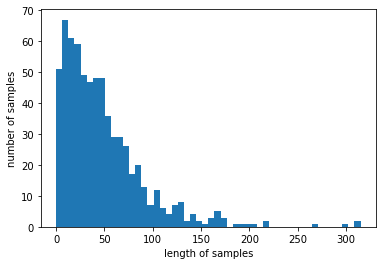

In [63]:
print('리뷰의 최대 길이 :',max(len(l) for l in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
#plt.show()
plt.savefig('감성분석 리뷰 길이.png')

In [64]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [66]:
max_len = 130
below_threshold_len(max_len, x_train)
#전체 훈련데이터 중 약 95%의 리뷰가 130 이하의 길이

전체 샘플 중 길이가 130 이하인 샘플의 비율: 95.25222551928783


In [67]:
#패딩
21ㅈ
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)
#모든 샘플의 길이를 130으로 맞춤

In [68]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [69]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [70]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [71]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
9/9 [==============================] - 3s 174ms/step - loss: 0.7000 - acc: 0.5778 - val_loss: 0.6527 - val_acc: 0.5926

Epoch 00001: val_acc improved from -inf to 0.59259, saving model to best_model.h5
Epoch 2/15
9/9 [==============================] - 1s 100ms/step - loss: 0.5889 - acc: 0.6917 - val_loss: 0.6067 - val_acc: 0.7111

Epoch 00002: val_acc improved from 0.59259 to 0.71111, saving model to best_model.h5
Epoch 3/15
9/9 [==============================] - 1s 98ms/step - loss: 0.4799 - acc: 0.8606 - val_loss: 0.5073 - val_acc: 0.7778

Epoch 00003: val_acc improved from 0.71111 to 0.77778, saving model to best_model.h5
Epoch 4/15
9/9 [==============================] - 1s 97ms/step - loss: 0.3025 - acc: 0.9078 - val_loss: 0.5952 - val_acc: 0.6741

Epoch 00004: val_acc did not improve from 0.77778
Epoch 5/15
9/9 [==============================] - 1s 98ms/step - loss: 0.3101 - acc: 0.8931 - val_loss: 0.4433 - val_acc: 0.7556

Epoch 00005: val_acc did not improve from 0.77

In [72]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

6/6 [==============================] - 0s 17ms/step - loss: 0.2516 - acc: 0.9286

 테스트 정확도: 0.9286


In [74]:
#위에서 생성한 모델을 words에 적용
def predict2(x):
    x = okt.morphs(x, stem=True)
    encoded = tokenizer.texts_to_sequences(x)
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(loaded_model.predict(pad_new))
    return score

In [75]:
tok = []
value = []
for ww in words:
    try :
        tok.append(ww)
        value.append(predict2(ww))
    except :
        value.append(np.nan)
        #토큰화가 되지 않는 단어들은 nan값으로 대체

In [76]:
gp = pd.DataFrame()
gp['단어'] = tok
gp['score'] = value

In [77]:
gp = sung.dropna(subset = ['score'])
#분석에 활용하지 못하는 nan값 제거

In [78]:
gp.sort_values('score', ascending = False).tail(50)

,단어,score
111,만,0.684509
46,나오,0.683013
247,예상,0.682169
373,티비,0.681305
251,옥탑,0.680747
159,부분,0.680142
79,당황,0.679640
297,전반,0.679561
176,사용,0.679391
284,작,0.679239


In [149]:
gp.sort_values('score', ascending = False).head(50)

,단어,score
156,보내,0.849172
199,쉬,0.841332
304,제공,0.840267
151,배려,0.838968
288,장소,0.838468
37,기구,0.837899
329,지하철역,0.835737
122,머무르,0.835672
34,그녀,0.834126
266,의사,0.831108


In [79]:
gp.score.median()

0.7603490352630615

## 주제분석

#### NMF

In [151]:
cv = TfidfVectorizer(max_features=2000)
x = cv.fit_transform(yr.review)

In [152]:
words = cv.get_feature_names()

In [153]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=80, random_state=1234)
doc_topics = nmf.fit_transform(x)

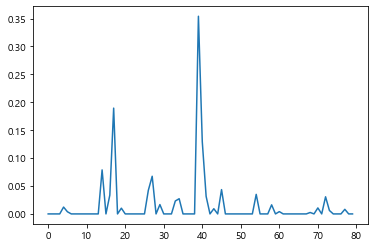

In [201]:
from matplotlib import pyplot
loading = nmf.components_
word_idx = words.index('청결')
pyplot.plot(loading[:, word_idx])

In [202]:
topic_idx = loading[:, word_idx].argmax()
topic_idx

39

In [203]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail(10)

,word,loading
1849,편리한,0.331775
1696,청결,0.354206
256,깨끗한,0.354871
872,서울을,0.385015
1697,청결도,0.405303
1459,장소와,0.417098
1546,좋고,0.461142
1369,인테리어,0.520949
971,시설,0.681864
1276,위치,7.244183


####  **LDA**

In [97]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [98]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [99]:
#Corpus 생성
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)
def tokenizer(text):
    words = []
    for word in token_re.findall(text):
        words.append(word)
    return words

In [100]:
docs = []
for text in yr.review:
    doc = tokenizer(text)
    docs.append(doc)

In [101]:
dic = Dictionary(docs)

In [102]:
dic.filter_extremes(no_below=10, no_above=0.90)

In [103]:
corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)

In [104]:
#LDA
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=126)

In [254]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=45,
    random_state=126)

In [255]:
old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

In [256]:
while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-11.552927961158469
-11.334367685768555
-11.229481832200415
-11.184984287637322


In [257]:
dic.token2id['화장실']
#단어

350

In [279]:
word_id = dic.token2id['분위기']
model.get_term_topics(word_id, 0.01)
#이 단어가 어느 주제에 많이 나오는지

[(20, 0.023868011)]

In [280]:
model.show_topic(20)

[('좋은', 0.043244928),
 ('호스트님의', 0.033362176),
 ('너무', 0.0313638),
 ('공간이었습니다', 0.028141564),
 ('분위기', 0.023990387),
 ('있었습니다', 0.02181704),
 ('빠른', 0.017901475),
 ('청결도', 0.016955199),
 ('만족스러웠습니다', 0.015617168),
 ('이용할', 0.015352348)]

In [263]:
#LDA 시각화
import pyLDAvis.gensim

In [264]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=False, mds='mmds')
pyLDAvis.display(p)

#### 응집도, 다양도

In [221]:
from gensim.models import CoherenceModel

In [222]:
#응집도
coh = CoherenceModel(model=model, corpus=corpus, texts=docs, dictionary=dic, coherence='c_v')

In [223]:
coh.get_coherence()

0.3432726932916385

In [210]:
#다양도
topn = 20
#각 주제별 tpon개 단어 뽑음
top_words = set()
#중복제외 순수하게 단어

for topic in range(model.num_topics):
    for word, prob in model.show_topic(topic, topn=topn):
        top_words.add(word)

In [211]:
len(top_words)

555

In [206]:
488/900
#토픽 100개 각 토픽별 상위 25개 -> 2500


0.5422222222222223